In [7]:
!nvidia-smi

Thu Aug  8 12:04:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    17W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# https://pytorch.org/get-started/previous-versions/
!pip3 install torch==1.0.1 -f https://download.pytorch.org/whl/cu100/stable # CUDA 10.0 build

Looking in links: https://download.pytorch.org/whl/cu100/stable
  Using cached https://files.pythonhosted.org/packages/f7/92/1ae072a56665e36e81046d5fb8a2f39c7728c25c21df1777486c49b179ae/torch-1.0.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 1.0.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0


In [0]:
!pip install torchvision

  Using cached https://files.pythonhosted.org/packages/69/60/f685fb2cfb3088736bafbc9bdbb455327bdc8906b606da9c9a81bae1c81e/torch-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.0.1
    Uninstalling torch-1.0.1:
      Successfully uninstalled torch-1.0.1


# MACHINE TRANSLATION TUTORIAL

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!wget https://www.manythings.org/anki/ces-eng.zip
!unzip ces-eng.zip

--2019-08-08 12:04:22--  https://www.manythings.org/anki/ces-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 294666 (288K) [application/zip]
Saving to: ‘ces-eng.zip’

ces-eng.zip         100%[===================>] 287.76K  --.-KB/s    in 0.1s    

2019-08-08 12:04:38 (2.22 MB/s) - ‘ces-eng.zip’ saved [294666/294666]

Archive:  ces-eng.zip
  inflating: ces.txt                 
  inflating: _about.txt              


In [0]:
!mkdir data
!mv ces.txt data/eng-ces.txt

In [6]:
with open("data/eng-ces.txt", "r") as f:
  for line in f.readlines()[:5]:
    print(line)

Hi.	Ahoj!

Wow!	Páni!

Fire!	Hoří!

Hello!	Ahoj!

Hurry!	Pospěš si!



In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [12]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'ces', True)
print(random.choice(pairs))

Reading lines...
Read 12731 sentence pairs
Trimmed to 811 sentence pairs
Counting words...
Counted words:
ces 1071
eng 737
['jsi opily .', 'you re drunk .']


In [13]:
pairs[:10]

[['jsem tlusty .', 'i m fat .'],
 ['jsem tlusta .', 'i m fat .'],
 ['jsem smutny .', 'i m sad .'],
 ['jsem smutna .', 'i m sad .'],
 ['je mi smutno .', 'i m sad .'],
 ['jsem mokry .', 'i m wet .'],
 ['jsem mokra .', 'i m wet .'],
 ['jsem tlusty .', 'i am fat .'],
 ['jsem tlusta .', 'i am fat .'],
 ['jsem bohaty .', 'i m rich .']]

## MODEL

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## TRAINING

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if isinstance(decoder, type(AttnDecoderRNN(1,1,1))):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if isinstance(decoder, type(AttnDecoderRNN(1,1,1))):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline 


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## EVALUATION

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)

decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, 75000, print_every=5000)

# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 0s (- 14m 10s) (5000 6%) 2.5735
1m 59s (- 12m 54s) (10000 13%) 1.2866
2m 58s (- 11m 54s) (15000 20%) 0.3884
3m 57s (- 10m 52s) (20000 26%) 0.1016
4m 55s (- 9m 51s) (25000 33%) 0.0470
5m 54s (- 8m 51s) (30000 40%) 0.0309
6m 51s (- 7m 50s) (35000 46%) 0.0261
7m 49s (- 6m 50s) (40000 53%) 0.0210
8m 46s (- 5m 51s) (45000 60%) 0.0208
9m 45s (- 4m 52s) (50000 66%) 0.0169
10m 43s (- 3m 53s) (55000 73%) 0.0165
11m 40s (- 2m 55s) (60000 80%) 0.0158
12m 38s (- 1m 56s) (65000 86%) 0.0147
13m 36s (- 0m 58s) (70000 93%) 0.0145
14m 33s (- 0m 0s) (75000 100%) 0.0136


In [24]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)

attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder2, attn_decoder1, 75000, print_every=5000)

1m 40s (- 23m 25s) (5000 6%) 2.5466
3m 18s (- 21m 29s) (10000 13%) 1.0577
4m 57s (- 19m 50s) (15000 20%) 0.2655
6m 37s (- 18m 12s) (20000 26%) 0.0690
8m 16s (- 16m 32s) (25000 33%) 0.0331
9m 55s (- 14m 53s) (30000 40%) 0.0254
11m 33s (- 13m 12s) (35000 46%) 0.0227
13m 12s (- 11m 33s) (40000 53%) 0.0217
14m 51s (- 9m 54s) (45000 60%) 0.0171
16m 30s (- 8m 15s) (50000 66%) 0.0172
18m 9s (- 6m 36s) (55000 73%) 0.0177
19m 47s (- 4m 56s) (60000 80%) 0.0160
21m 26s (- 3m 17s) (65000 86%) 0.0149
23m 5s (- 1m 38s) (70000 93%) 0.0136
24m 44s (- 0m 0s) (75000 100%) 0.0120


In [29]:
evaluateRandomly(encoder1, attn_decoder1)

> jsi tady novy .
= you re new here .
< you re new here . <EOS>

> kresli obrazek .
= she is drawing a picture .
< she is drawing a picture . <EOS>

> je to prosty clovek .
= he is a simple man .
< he is a simple man . <EOS>

> jsem si jisty ze je to pravda .
= i m sure that s true .
< i m sure that s true . <EOS>

> jsem americanka .
= i am american .
< i am american . <EOS>

> dnes budu odpocivat .
= i m going to rest today .
< i m going to rest today . <EOS>

> mne je taky sedmnact .
= i am seventeen years old too .
< i am seventeen years old too . <EOS>

> bojim se preskocit prikop .
= i am afraid to jump over the ditch .
< i am afraid to jump over the ditch . <EOS>

> lezim .
= i m lying .
< i m lying . <EOS>

> stale tomu neverim .
= i m still not buying it .
< i m still not buying it . <EOS>



In [61]:
evaluate(encoder1, attn_decoder1, "jsem smutna .")

(['i', 'm', 'sad', '.', '<EOS>'],
 tensor([[6.5681e-05, 8.6707e-05, 9.9850e-01, 5.7638e-04, 2.9498e-04, 1.1838e-05,
          1.3119e-04, 5.9800e-05, 1.2943e-04, 1.4843e-04],
         [2.8752e-05, 1.6711e-04, 9.9612e-01, 2.3363e-05, 2.8282e-03, 5.0686e-04,
          1.9877e-04, 8.3946e-06, 3.2976e-05, 8.1632e-05],
         [1.6707e-06, 1.5890e-06, 9.9986e-01, 3.9152e-06, 1.0845e-08, 5.5237e-05,
          1.2713e-05, 7.8485e-06, 2.3660e-05, 3.0872e-05],
         [3.3490e-03, 3.6313e-04, 1.1846e-03, 8.8235e-01, 1.7227e-06, 1.7202e-04,
          8.4491e-02, 2.9525e-03, 2.1235e-02, 3.9056e-03],
         [4.5534e-02, 1.0544e-01, 2.9830e-02, 6.5754e-02, 5.7587e-03, 5.3327e-03,
          1.2100e-01, 2.4542e-01, 1.1928e-01, 2.5665e-01]]))

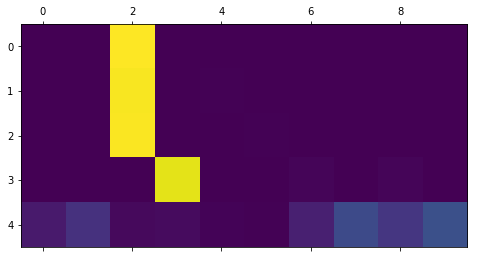

In [62]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "jsem smutna .")
plt.matshow(attentions.numpy())

input = je o pet let starsi nez ja .
output = he is badly years old . <EOS>


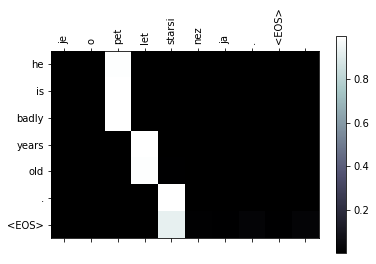

input = je smutny asi .
output = he is clumsy now . <EOS>


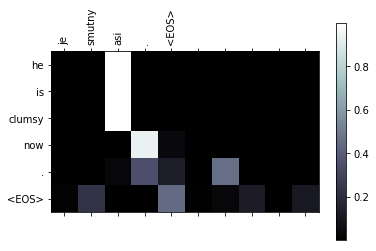

input = nechci mluvit .
output = i m not buying to get better . <EOS>


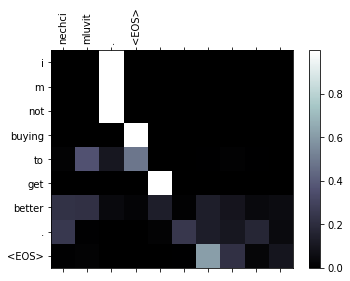

In [64]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("je o pet let starsi nez ja .")

evaluateAndShowAttention("je smutny asi .")

evaluateAndShowAttention("nechci mluvit .")

# evaluateAndShowAttention("c est un jeune directeur plein de talent .")